In [1]:
import numpy as np
import bms_env_new_2

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random

import pandas as pd




from utils import *


# Import the necessary libraries
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env

from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.data.types import TrajectoryWithRew
from imitation.data import rollout
from imitation.algorithms import bc
from imitation.data.types import Transitions
import torch



In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures

# # Data from the image
# data = np.array([
#     [0.9, 0.1063, 0.0303, 726.32, 0.0099, 636.78],
#     [0.8, 0.1016, 0.0302, 734.10, 0.0102, 594.41],
#     [0.7, 0.1020, 0.0315, 766.53, 0.0105, 575.44],
#     [0.6, 0.1023, 0.0390, 929.76, 0.0078, 613.48],
#     [0.5, 0.1024, 0.0271, 1131.40, 0.0078, 789.73],
#     [0.4, 0.1040, 0.0275, 1161.67, 0.0077, 791.77],
#     [0.3, 0.1042, 0.0272, 1128.74, 0.0077, 788.39],
#     [0.2, 0.1070, 0.0272, 982.50, 0.0076, 746.24],
#     [0.1, 0.1325, 0.0498, 747.54, 0.0096, 639.61]
# ])

# # Splitting the data
# X = data[:, 0].reshape(-1, 1)  # SoC values
# Y = data[:, 1:]  # Remaining columns

# # Transform input data to include quadratic terms
# poly = PolynomialFeatures(degree= 4)
# X_poly = poly.fit_transform(X)

# # Train a model for each output
# models = []
# for i in range(Y.shape[1]):
#     model = LinearRegression()
#     model.fit(X_poly, Y[:, i])
#     models.append(model)

# # Generate a range of SoC values for prediction
# X_plot = np.linspace(0.1, 0.9, 100).reshape(-1, 1)
# X_plot_poly = poly.transform(X_plot)

# # Plotting
# fig, axs = plt.subplots(5, 1, figsize=(10, 20))
# output_labels = ['R0 (Ω)', 'R1 (Ω)', 'C1 (F)', 'R2 (Ω)', 'C2 (F)']

# for i, ax in enumerate(axs):
#     predictions = models[i].predict(X_plot_poly)
#     ax.scatter(X, Y[:, i], color='red', label='Data Points')
#     ax.plot(X_plot, predictions, label='Fit')
#     ax.set_title(f'Model for {output_labels[i]}')
#     ax.set_xlabel('State of Charge (SoC)')
#     ax.set_ylabel(output_labels[i])
#     ax.legend()

# plt.tight_layout()
# plt.show()

In [3]:
num_cells = 100
bms = bms_env_new_2.BMSenv(num_cells= num_cells, k_tanh_params= np.random.uniform(0, 0.12, num_cells),
                          Q_cells =np.random.uniform(3., 4. ,num_cells), w_reward=1_000, var_weight= 0.0, 
                          max_min_weight= 1., switch_weight= 0.0)

T = 20_000


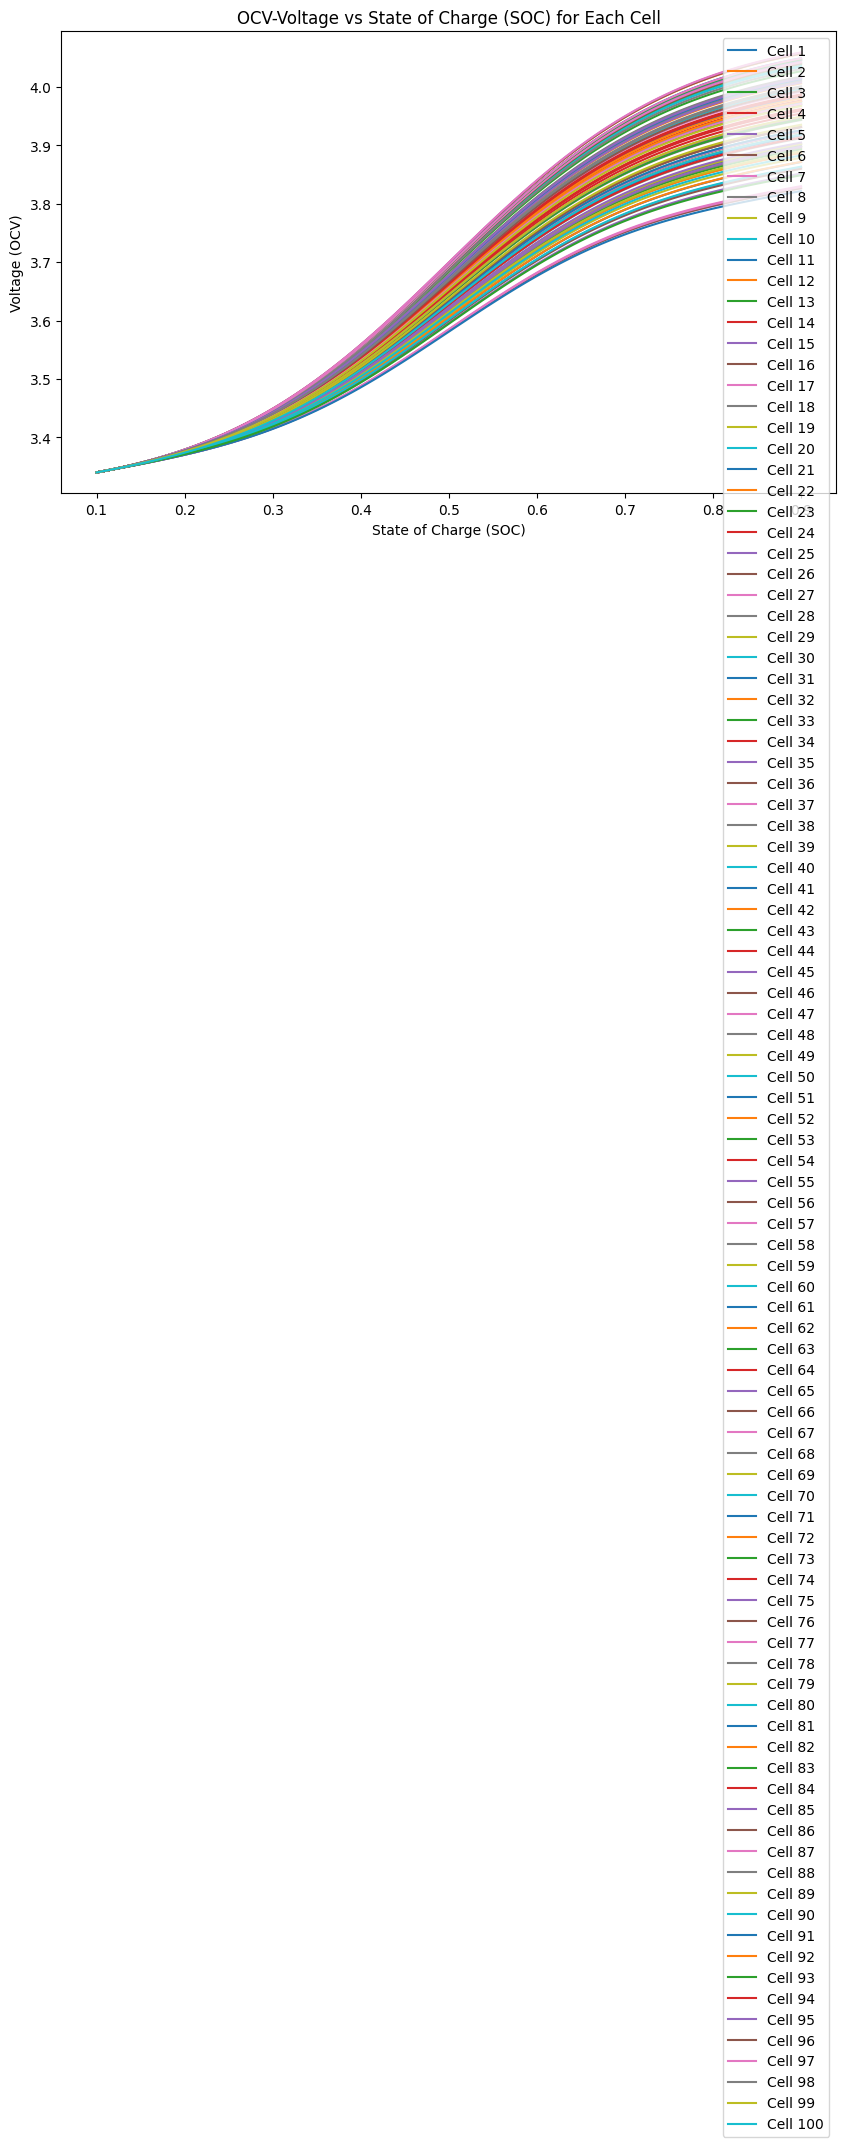

In [4]:
plot_voltage_vs_soc(bms)

# Always disconected (All the batteries stay still)

In [5]:
bms.reset(seed = 0)
states_soc_1 = [bms.state[:num_cells]]
states_voltage_1 = [bms.state[num_cells:]]
actions_1 = []
rewards_1 = []
dones_1 = [False]

while not dones_1[-1] and len(states_soc_1) < T:
    action = [0 for _ in range(num_cells)]


    actions_1.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_1.append(state[:num_cells])
    states_voltage_1.append(state[num_cells:])
    rewards_1.append(reward)
    dones_1.append(done)

print(f"Sum of rewards: {np.sum(rewards_1)}")

charge_end_1 = len(states_soc_1)
mean_capacity_1 = np.mean(states_soc_1[-1])
min_capacity_1 = np.min(states_soc_1[-1])
actions_1 = np.array(actions_1)
stds_1 = np.std(states_soc_1[-1])
mismatches_1 = sum([np.sum(actions_1[i] != actions_1[i+1]) for i in range(len(actions_1) - 1)])




while states_soc_1[-1].min() > 0.1:
    bms.discharge()
    states_soc_1.append(bms.state[:num_cells])
    states_voltage_1.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_1}")
print(f"Length of discharge: {len(states_soc_1) - charge_end_1}")
print(f"Total length: {len(states_soc_1)}")
print(f"Mean capacity: {np.round(mean_capacity_1, 3)}")
print(f"Min capacity: {np.round(min_capacity_1, 3)}")
print(f"Number of mismatches: {mismatches_1}")

data = {
    "Length of charge": [charge_end_1],
    "Length of discharge": [len(states_soc_1) - charge_end_1],
    "Total length": [len(states_soc_1)],
    "Standard Deviation": [stds_1],
    "Mean capacity": [np.round(mean_capacity_1, 3)],
    "Min capacity": [np.round(min_capacity_1, 3)],
    "Number of switches": [mismatches_1]
}

df = pd.DataFrame(data)
np.round(df, 4).T


Sum of rewards: 23.877057446951333
Length of charge: 95
Length of discharge: 95
Total length: 190
Mean capacity: 0.717
Min capacity: 0.57
Number of mismatches: 0


,0
Length of charge,95.0000
Length of discharge,95.0000
Total length,190.0000
Standard Deviation,0.0789
Mean capacity,0.7170
Min capacity,0.5700
Number of switches,0.0000


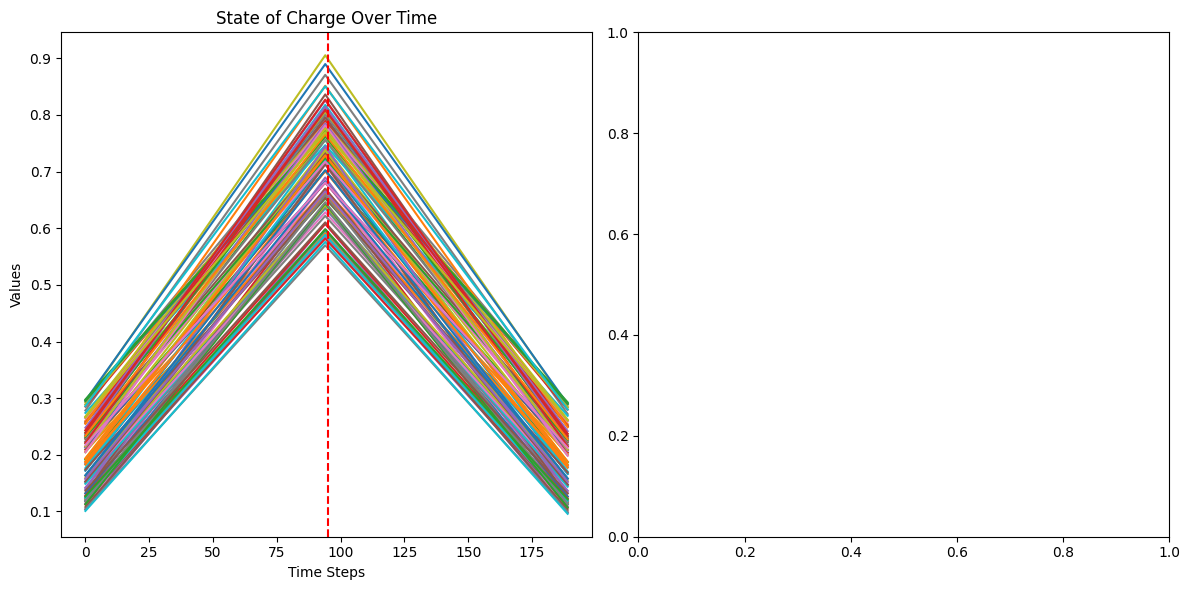

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_1, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_1, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_1, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_1, color='r', linestyle='--', label='Charge End')


plt.tight_layout()  # Adjust layout to prevent overlap


KeyboardInterrupt: 

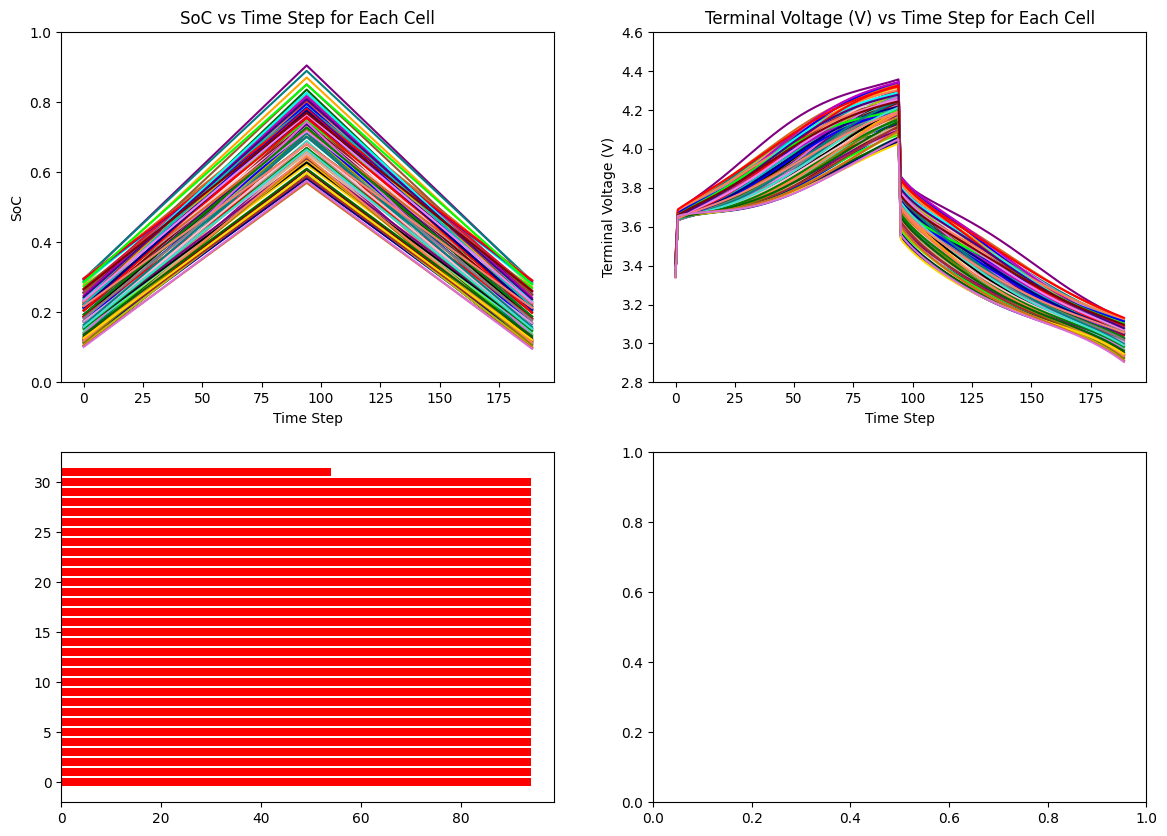

In [8]:
plot_bms_evolution(bms, states_soc_1, states_voltage_1, actions_1, rewards_1, dones_1)

# Rule-Based


In [50]:
bms.reset(seed = 0)
states_soc_4 = [bms.state[:num_cells]]
states_voltage_4 = [bms.state[num_cells:]]
actions_4 = []
rewards_4 = []
dones_4 = [False]

states = [bms.state.tolist()]
actions = []
dones = []

while not dones_4[-1] and len(states_soc_4) < T:
    median_soc = np.median(states_soc_4[-1])
    action = [1 if soc > (states_soc_4[-1].min()  + 0.21) else 0 for soc in states_soc_4[-1]]
    actions_4.append(action)
    actions.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_4.append(state[:num_cells])
    states_voltage_4.append(state[num_cells:])
    rewards_4.append(reward)
    dones_4.append(done)
    dones.append(done)
    states.append(state.tolist())

print(f"Sum of rewards: {np.sum(rewards_4)}")

charge_end_4 = len(states_soc_4)
mean_capacity_4 = np.mean(states_soc_4[-1])
min_capacity_4 = np.min(states_soc_4[-1])
actions_4 = np.array(actions_4)
stds_4 = np.std(states_soc_4[-1])
mismatches_4 = sum([np.sum(actions_4[i] != actions_4[i+1]) for i in range(len(actions_4) - 1)])




while states_soc_4[-1].min() > 0.1:
    bms.discharge()
    states_soc_4.append(bms.state[:num_cells])
    states_voltage_4.append(bms.state[num_cells:])


data = {
    "Length of charge": [charge_end_4],
    "Length of discharge": [len(states_soc_4) - charge_end_4],
    "Total length": [len(states_soc_4)],
    "Standard Deviation": [stds_4],
    "Mean capacity": [np.round(mean_capacity_4, 3)],
    "Min capacity": [np.round(min_capacity_4, 3)],
    "Number of switches": [mismatches_4]
}

df = pd.DataFrame(data)
np.round(df, 4).T


Sum of rewards: 4.203760696426328


,0
Length of charge,120.0000
Length of discharge,120.0000
Total length,240.0000
Standard Deviation,0.0663
Mean capacity,0.8390
Min capacity,0.6940
Number of switches,901.0000


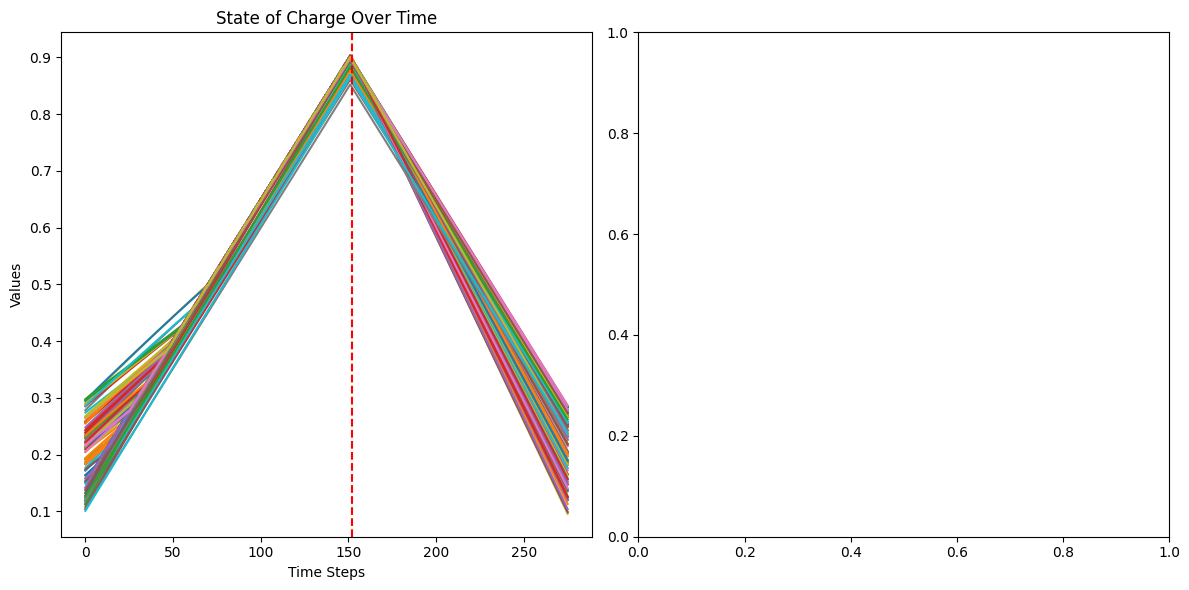

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_4, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_4, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_4, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_4, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap


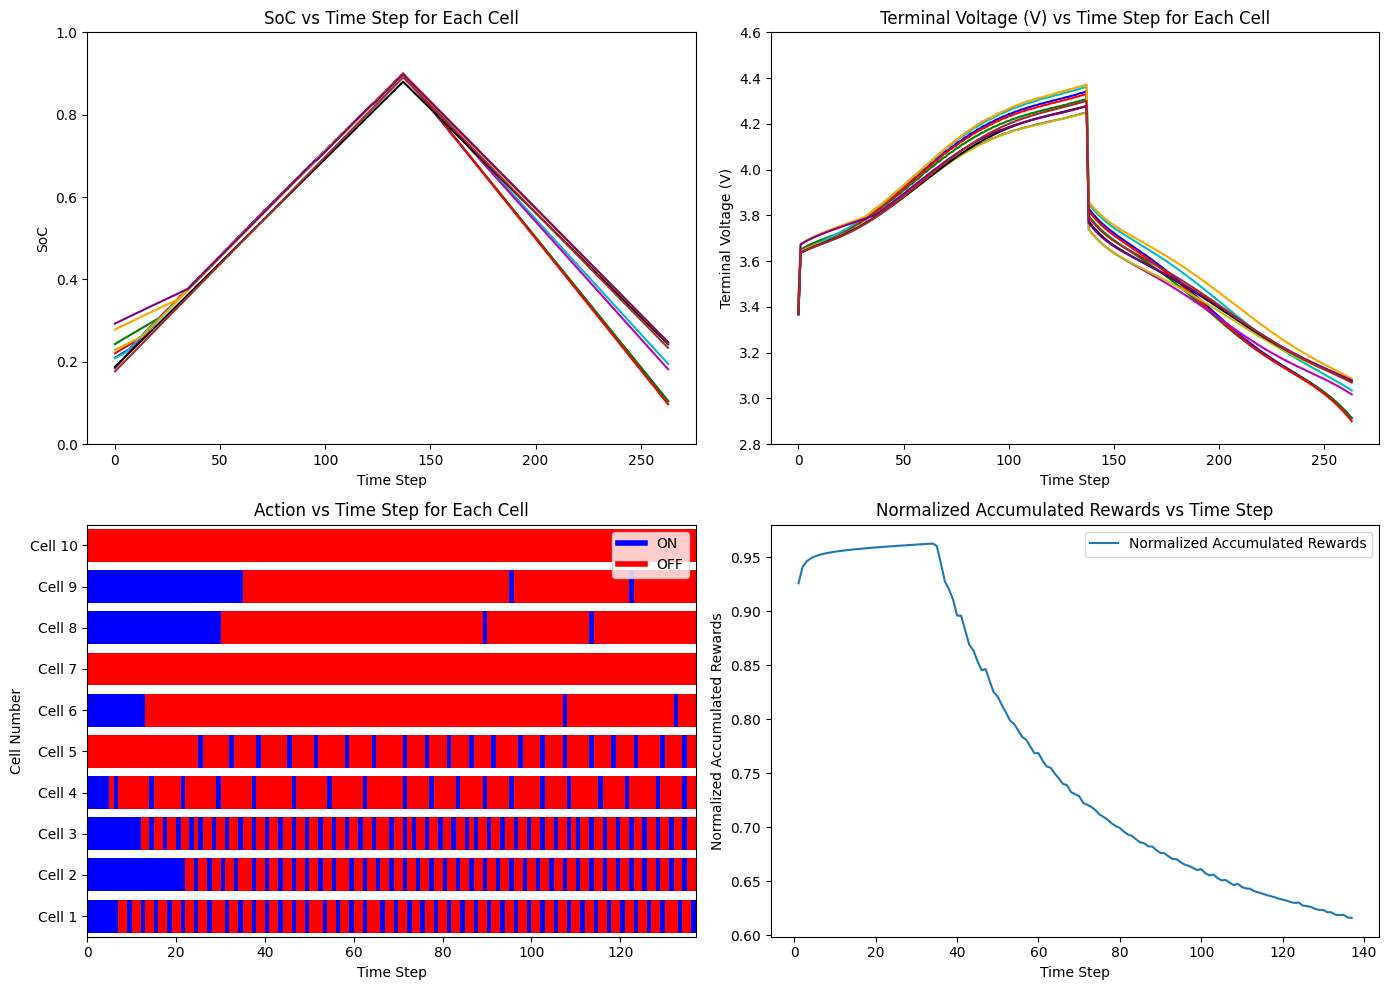

In [10]:
plot_bms_evolution(bms, states_soc_4, states_voltage_4, actions_4, rewards_4, dones_4)

# Imitation Learning with Rule Based Expert

In [1]:
from tqdm import tqdm

trajectories = []

num_episodes = 1

for i in tqdm(range(num_episodes)):
    

    bms.reset(seed = i)
    states_soc_4 = [bms.state[:num_cells]]
    states_voltage_4 = [bms.state[num_cells:]]
    actions_4 = []
    rewards_4 = []
    dones_4 = [False]

    states = [bms.state.tolist()]
    actions = []
    dones = []

    while not dones_4[-1] and len(states_soc_4) < T:
        median_soc = np.median(states_soc_4[-1])
        action = [1 if soc > (states_soc_4[-1].min()  + 0.02) else 0 for soc in states_soc_4[-1]]
        actions_4.append(action)
        actions.append(action)
        state, reward, done, _, _ = bms.step(action)
        states_soc_4.append(state[:num_cells])
        states_voltage_4.append(state[num_cells:])
        rewards_4.append(reward)
        dones_4.append(done)
        dones.append(done)
        states.append(state.tolist())

    # print(f"Sum of rewards: {np.sum(rewards_4)}")


    states = np.array(states)
    actions = np.array(actions)


    trajectory = TrajectoryWithRew(
        obs=states,
        acts=actions.astype(float),
        infos=[{} for _ in range(len(actions))],
        rews=np.zeros(len(actions),) ,
        terminal= True
    )

    trajectories.append(trajectory)

   

  0%|          | 0/1 [00:00<?, ?it/s]


NameError: name 'bms' is not defined

In [ ]:
import pickle

# Load trajectories from the binary file
with open('trajectories.pkl', 'rb') as f:
    trajectories = pickle.load(f)

print("Trajectories loaded from 'trajectories.pkl'")
print(f"Number of trajectories: {len(trajectories)}")



Trajectories loaded from 'trajectories.pkl'
Number of trajectories: 40416


In [58]:
import torch
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
from torch.optim import Adam

# Assuming the environment is already loaded
env = bms

class CustomPolicy(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=128):  # Adjust as necessary
        super(CustomPolicy, self).__init__(observation_space, features_dim)
        # Input dimension is 150 (state size), and output dimension is 50 (action size)
        self.net = nn.Sequential(
            nn.Linear(150, 128),  # First layer receives state input
            nn.ReLU(),
            nn.Linear(128, 64),  # Intermediate layer for processing
            nn.ReLU(),
            nn.Linear(64, 50)   # Output layer matches the action dimension
        )

    def forward(self, observations):
        # Process the batch of observations
        return self.net(observations)

# Create a PPO policy with custom features extractor
model = PPO("MlpPolicy", env, policy_kwargs={"features_extractor_class": CustomPolicy}, verbose=1)
model.policy.train()  # Ensure the policy is in training mode

def train_behavior_cloning(model, states, actions, epochs=10, batch_size=64):
    optimizer = Adam(model.policy.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        permutation = np.random.permutation(len(states))
        for i in range(0, len(states), batch_size):
            indices = permutation[i:i + batch_size]
            batch_states, batch_actions = states[indices], actions[indices]

            batch_states = torch.tensor(batch_states, dtype=torch.float32)
            batch_actions = torch.tensor(batch_actions, dtype=torch.float32)

            optimizer.zero_grad()
            action_logits = model.policy(batch_states)

            loss = criterion(action_logits, batch_actions)
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Load your expert data
states = np.random.rand(157, 150)  # Simulated state data
actions = np.random.rand(157, 50)  # Simulated action data

train_behavior_cloning(model, states, actions)

model.save("ppo_pretrained")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x50 and 128x64)

In [16]:
bc_trainer = bc.BC(
    observation_space=bms.observation_space,
    action_space=bms.action_space,
    demonstrations=rollout.flatten_trajectories(trajectories),
    rng=np.random.default_rng(),
    batch_size= 2**6,
)



In [12]:
bc_trainer.train(n_epochs=1_0)  

NameError: name 'bc_trainer' is not defined

In [61]:
bms.reset(seed  =0)
states_soc_7 = [bms.state[:num_cells]]
states_voltage_7 = [bms.state[num_cells:]]
actions_7 = []
rewards_7 = []
dones_7 = [False]

state = bms.state.copy()
while not dones_7[-1] and len(states_soc_7) < T:


    observation_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    bc_trainer.policy(observation_tensor)[0].numpy().squeeze()

    action = bc_trainer.policy(observation_tensor)[0].numpy().squeeze().tolist()

    actions_7.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_7.append(state[:num_cells])
    states_voltage_7.append(state[num_cells:])
    rewards_7.append(reward)
    dones_7.append(done)

print(f"Sum of rewards: {np.sum(rewards_7)}")

charge_end_7 = len(states_soc_7)
mean_capacity_7 = np.mean(states_soc_7[-1])
min_capacity_7 = np.min(states_soc_7[-1])
actions_7 = np.array(actions_7)
stds_7 = np.std(states_soc_7[-1])
mismatches_7 = sum([np.sum(actions_7[i] != actions_7[i+1]) for i in range(len(actions_7) - 1)])



while states_soc_7[-1].min() > 0.1:
    bms.discharge()
    states_soc_7.append(bms.state[:num_cells])
    states_voltage_7.append(bms.state[num_cells:])



data = {
    "Length of charge": [charge_end_7],
    "Length of discharge": [len(states_soc_7) - charge_end_7],
    "Total length": [len(states_soc_7)],
    "Standard Deviation": [stds_7],
    "Mean capacity": [np.round(mean_capacity_7, 3)],
    "Min capacity": [np.round(min_capacity_7, 3)],
    "Number of switches": [mismatches_7]
}

df = pd.DataFrame(data)
np.round(df, 4).T



Sum of rewards: -4138


,0
Length of charge,134.0000
Length of discharge,96.0000
Total length,230.0000
Standard Deviation,0.0418
Mean capacity,0.8010
Min capacity,0.6920
Number of switches,1633.0000


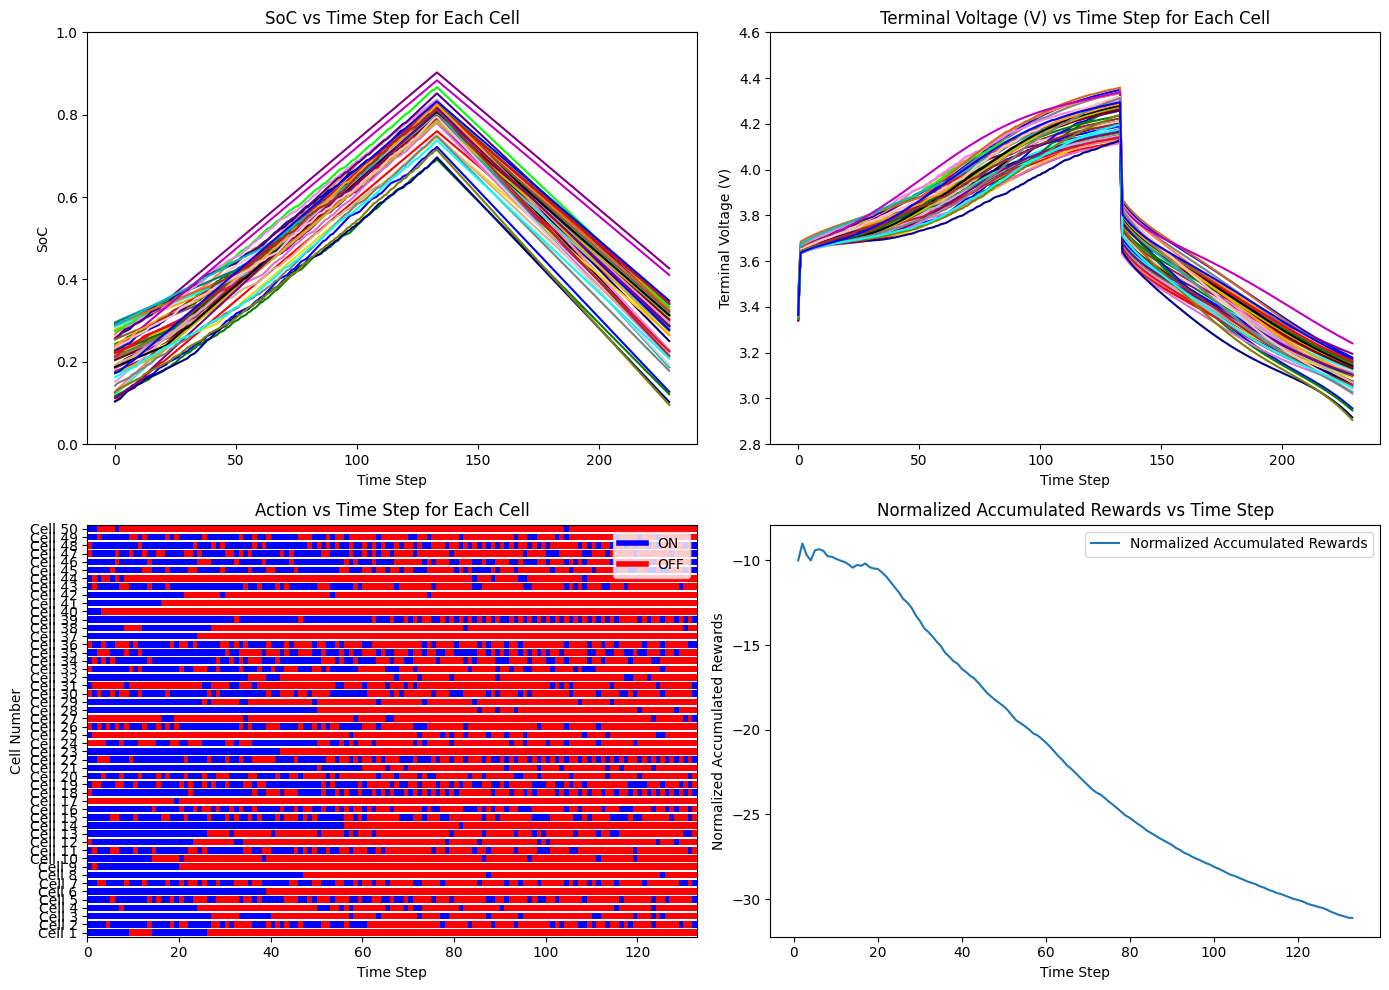

In [62]:
plot_bms_evolution(bms, states_soc_7, states_voltage_7, actions_7, rewards_7, dones_7)

# Q Learning (Efficient)

In [ ]:
bins = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


In [ ]:
init_Q_value = -0.1
Q = defaultdict(lambda: init_Q_value)

In [ ]:
num_episodes = 1

memory_threshold = init_Q_value

for episode in range(num_episodes):

    if episode == num_episodes - 5:
        bms.reset(seed =0)
    else:
        bms.reset(seed = 0)

    states_soc_6 = [bms.state[:num_cells]]
    states_voltage_6 = [bms.state[num_cells:]]
    actions_6 = []
    rewards_6 = []
    dones_6 = [False]
    random_actions_6 = []
    actions_int_6 = []
    states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

    epsilon = 0.1
    stepsize = 0.5
    gamma = 0.99

    if episode  >= num_episodes - 1:
        epsilon = 0.0

    while not dones_6[-1] and len(states_soc_6) < T:

        # if len(dones_6) % 1000 == 0:
        #     print('\n')
        #     print(f"Episode: {episode + 1}")
        #     print(f"Timesteps: {len(dones_6)}")
        #     print(f"Memory Threshold:" , memory_threshold)
        #     print(f"Number of unique (state, action) pairs: {len(Q)}")

        state_int = tuple(discretize_features(states_soc_6[-1], bins))

        if np.random.uniform(0, 1) < epsilon:
            random_actions_6.append(True)
            action = bms.action_space.sample()
        else:
            random_actions_6.append(False)
            # Collect all actions with non-zero Q-values for the current state
            state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

            if state_actions:
                max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
                max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
                action_int = random.choice(max_actions)
                action = np.array(action_int)
                if max_q_value < init_Q_value:
                    action = bms.action_space.sample()
                    random_actions_6[-1] = True
            else:
                action = bms.action_space.sample()
                random_actions_6[-1] = True

        action_int = tuple(action)
        actions_int_6.append(action_int)

        state, reward, done, _, _ = bms.step(action)
        state_soc = state[:num_cells]
        state_voltage = state[num_cells:]
        states_soc_6.append(state_soc)
        states_voltage_6.append(state_voltage)
        actions_6.append(action)
        rewards_6.append(reward)
        dones_6.append(done)

        if not done:
            next_state_int = tuple(discretize_features(state_soc, bins))
            states_int_6.append(next_state_int)
            next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
            if next_state_actions:
                max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
            else:
                max_next_q_value = init_Q_value

            if (state_int, action_int) not in Q:
                Q[(state_int, action_int)] = init_Q_value

            Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
                reward + gamma * max_next_q_value - Q[(state_int, action_int)]
            )

        # Remove entries with Q-values less than 0.0
        Q = {k: v for k, v in Q.items() if v >= memory_threshold}

        if len(Q) > 1500:
            memory_threshold/=1.1
        if len(Q) < 500 and (np.abs(memory_threshold) < 100):
            memory_threshold*=1.1



    if episode % 1 == 0:
        print('\n\n')
        print(f"Episode: {episode + 1}")
        print(f"Sum of rewards: {np.sum(rewards_6)}")
        print(f"Timesteps: {len(dones_6)}")
        print(f"Number of states visited: {len(set(states_int_6))}")
        print(f"Number of random actions: {sum(random_actions_6)}")
        print(f"Number of unique (state, action) pairs: {len(Q)}")

charge_end_6 = len(states_soc_6)
mean_capacity_6 = np.mean(states_soc_6[-1])
min_capacity_6 = np.min(states_soc_6[-1])
actions_6 = np.array(actions_6)
stds_6 = np.std(states_soc_6[-1])
mismatches_6 = sum([np.sum(actions_6[i] != actions_6[i+1]) for i in range(len(actions_6) - 1)])


while states_soc_6[-1].min() > 0.1:
    bms.discharge()
    states_soc_6.append(bms.state[:num_cells])
    states_voltage_6.append(bms.state[num_cells:])

print(f"\n\n\nLength of charge: {charge_end_6}")
print(f"Length of discharge: {len(states_soc_6) - charge_end_6}")
print(f"Total length: {len(states_soc_6)}")
print(f"Mean capacity: {np.round(mean_capacity_6, 3)}")
print(f"Min capacity: {np.round(min_capacity_6, 3)}")
print(f"Standard Deviation: {np.round(stds_6, 3)}")
print(f"Number of switches: {mismatches_6}")




Episode: 1
Sum of rewards: 45.08567025388484
Timesteps: 156
Number of states visited: 52
Number of random actions: 1
Number of unique (state, action) pairs: 50960



Length of charge: 156
Length of discharge: 124
Total length: 280
Mean capacity: 0.844
Min capacity: 0.77
Standard Deviation: 0.042
Number of switches: 241


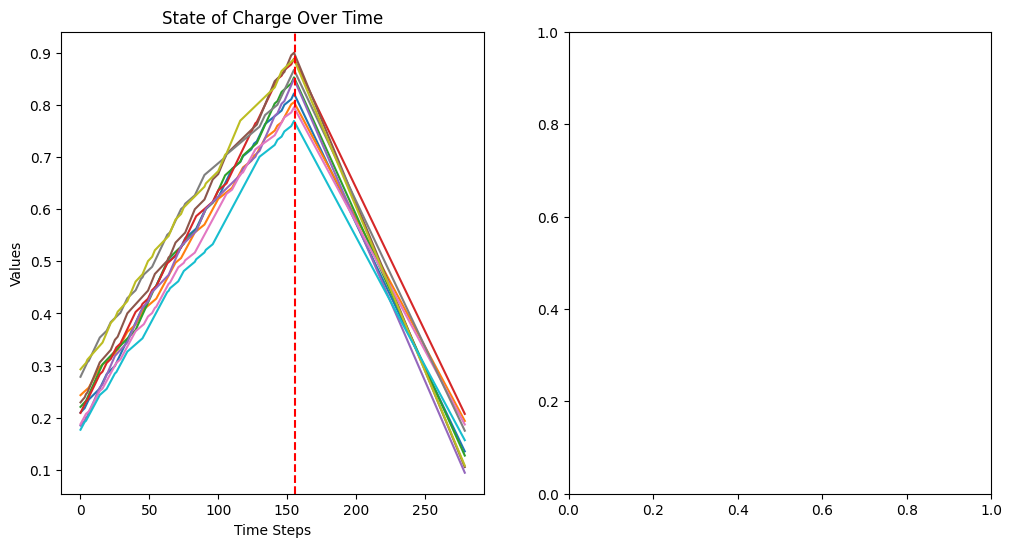

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_6, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_6, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_6, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_6, color='r', linestyle='--', label='Charge End')

# plt.tight_layout()  # Adjust layout to prevent overlap


In [13]:
from stable_baselines3.common.callbacks import BaseCallback

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.variances = []
        self.mean_capacities = []
        self.min_capacities = []
        self.episode_count = 0
        self.previous_action = None
        self.mismatches = 0
        self.total_differences = 0
        self.episode_differences = []

    def _on_step(self) -> bool:
        # Check if the episode is done
        if self.locals['dones'][0]:
            
            # Calculate the variance of the state
            terminal_soc = self.locals['infos'][0]['terminal_observation'][:num_cells]
            state_variance = np.var(terminal_soc)
            mean_capacity = np.mean(terminal_soc)
            min_capacity = np.min(terminal_soc)

            self.variances.append(state_variance)
            self.mean_capacities.append(mean_capacity)
            self.min_capacities.append(min_capacity)
            self.episode_count += 1

            # Append the total differences of this episode to the list
            self.episode_differences.append(self.total_differences)
            self.total_differences = 0  # Reset for the next episode

            # Print average variance and average differences every 5 episodes
            if self.episode_count % 20 == 0:
                average_variance = np.mean(self.variances)
                average_mean_capacity = np.mean(self.mean_capacities)
                average_min_capacity = np.mean(self.min_capacities)
                average_differences = np.mean(self.episode_differences)
                print('\n')
                print(f"Average State Variance after {self.episode_count} episodes: {average_variance:.3f}")
                print(f"Mean capacity after {self.episode_count} episodes: {average_mean_capacity:.3f}")
                print(f"Min capacity after {self.episode_count} episodes: {average_min_capacity:.3f}")
                print(f"Average Action Differences after {self.episode_count} episodes: {average_differences:.3f}")
                self.variances = []  # Reset the list to start collecting for the next batch of episodes
                self.episode_differences = []  # Reset the differences list

        # Track mismatches in actions
        last_action = self.locals['obs_tensor'].squeeze().numpy()[-num_cells:]
        current_action = self.locals['new_obs'].squeeze()[-num_cells:]

       
        # Calculate the number of different action components
        action_differences = np.sum(last_action != current_action)
        self.total_differences += action_differences

        # # Update the previous action
        # self.previous_action = current_action

        return True


# PPO

In [22]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [23]:
model = PPO("MlpPolicy", bms,  verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [32]:
bms.var_weight = 0.0
bms.max_min_weight = 0.20
bms.switch_weight = 0.80

In [33]:
print(bms.var_weight, bms.max_min_weight, bms.switch_weight)

0.0 0.2 0.8


In [34]:
model.save("ppo_bms")
model = PPO.load("ppo_bms", env=bms)
# model.learning_rate = 0.0001
model.save("ppo_bms")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [37]:
model = PPO.load("ppo_bms", env=bms)
model.learn(total_timesteps= 150_000, callback=CustomCallback())
model.save("ppo_bms")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 157      |
|    ep_rew_mean     | 3.67     |
| time/              |          |
|    fps             | 583      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


Average State Variance after 20 episodes: 0.000
Mean capacity after 20 episodes: 0.897
Min capacity after 20 episodes: 0.884
Average Action Differences after 20 episodes: 2233.350
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 158         |
|    ep_rew_mean          | 3.61        |
| time/                   |             |
|    fps                  | 476         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/               

In [44]:
model = PPO.load("ppo_bms")

bms.reset()
states_soc_5 = [bms.state[:num_cells]]
states_voltage_5 = [bms.state[num_cells:]]
actions_5_int = []
actions_5 = []
rewards_5 = []
dones_5 = [False]

state = bms.state.copy()
while not dones_5[-1] and len(states_soc_5) < T:
    state_1 = state.copy()


    action, _ = model.predict(state, deterministic= False)
    action = int(action)
    actions_5_int.append(action)
    state, reward, done, _, _ = bms.step(action)
    actions_5.append(state[-num_cells:])
    states_soc_5.append(state[:num_cells])
    states_voltage_5.append(state[num_cells:])
    rewards_5.append(reward)
    dones_5.append(done)

print(f"Sum of rewards: {np.sum(rewards_5)}")

charge_end_5 = len(states_soc_5)
mean_capacity_5 = np.mean(states_soc_5[-1])
min_capacity_5 = np.min(states_soc_5[-1])
stds_5 = np.std(states_soc_5[-1])
mismatches_5 = sum([np.sum(actions_5[i] != actions_5[i+1]) for i in range(len(actions_5) - 1)])



while states_soc_5[-1].min() > 0.1:
    bms.discharge()
    states_soc_5.append(bms.state[:num_cells])
    states_voltage_5.append(bms.state[num_cells:])


import pandas as pd

data = {
    "Length of charge": [charge_end_5],
    "Length of discharge": [len(states_soc_5) - charge_end_5],
    "Total length": [len(states_soc_5)],
    "Standard Deviation": [stds_5],
    "Mean capacity": [np.round(mean_capacity_5, 3)],
    "Min capacity": [np.round(min_capacity_5, 3)],
    "Number of switches": [mismatches_5]
}

df = pd.DataFrame(data)
np.round(df, 4).T





Sum of rewards: 10.184809589707402


,0
Length of charge,148.0000
Length of discharge,124.0000
Total length,272.0000
Standard Deviation,0.0175
Mean capacity,0.8750
Min capacity,0.8450
Number of switches,1050.0000


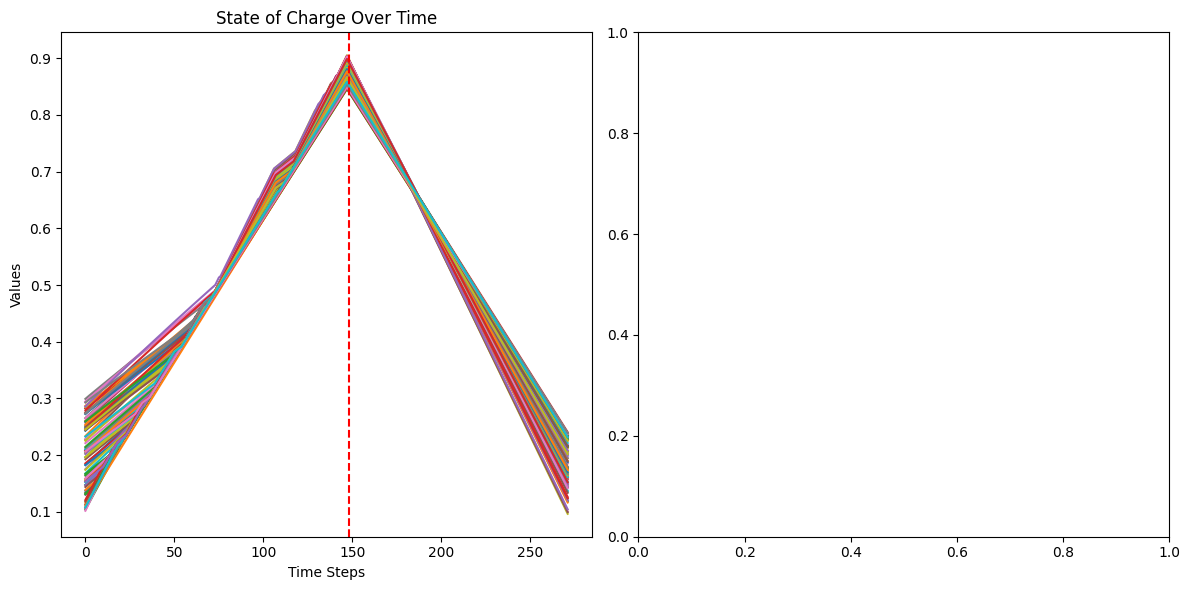

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_5, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_5, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_5, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_5, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap


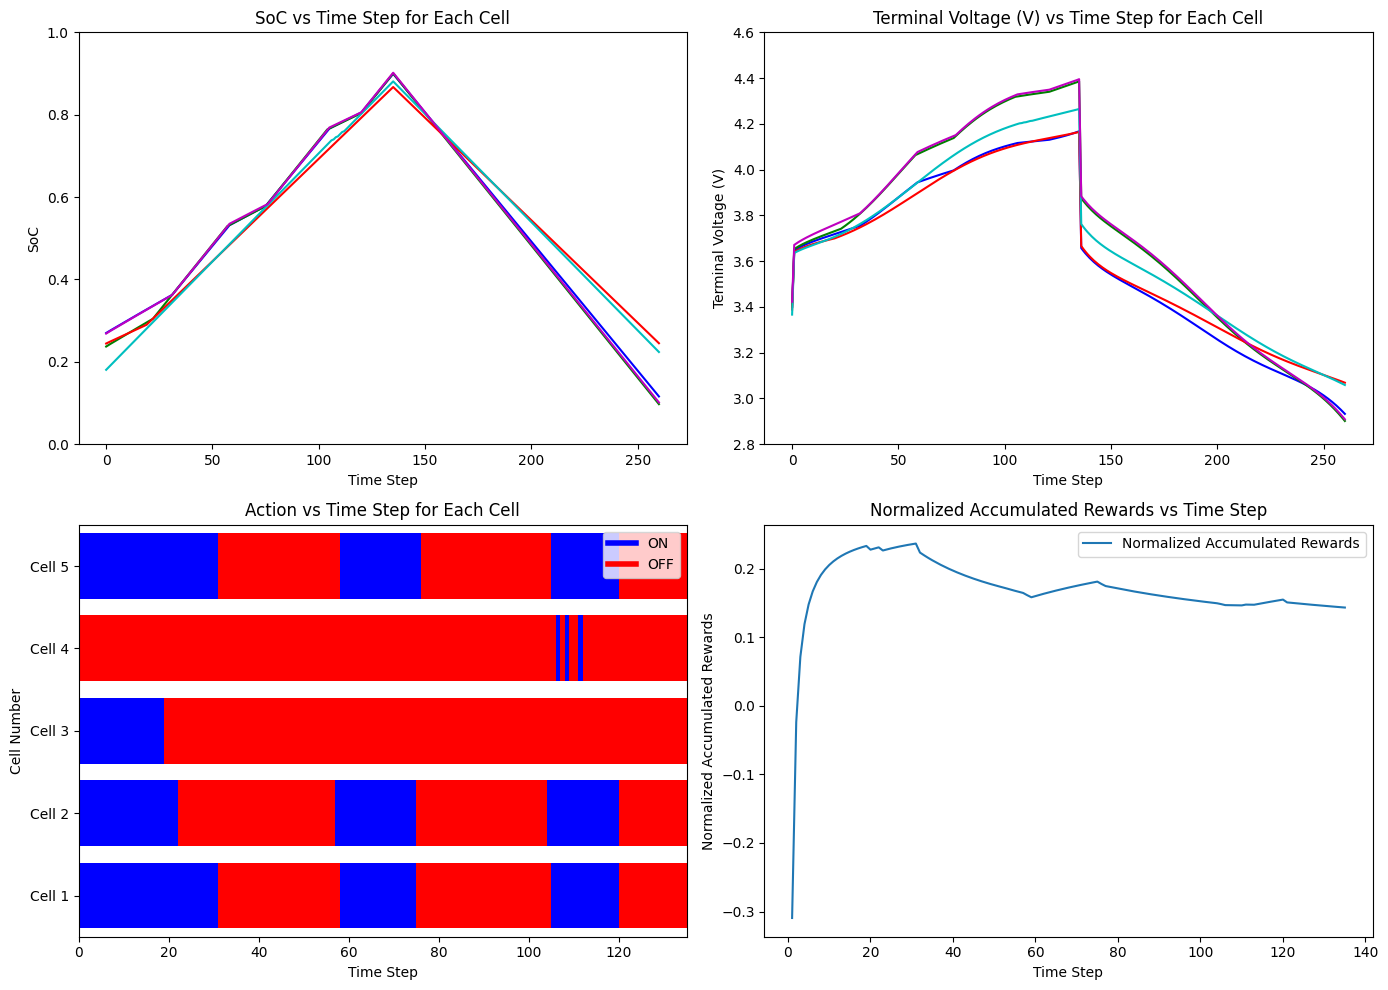

In [53]:
plot_bms_evolution(bms, states_soc_5, states_voltage_5, actions_5, rewards_5, dones_5, include_bad_rewards=False)


In [67]:
from stable_baselines3.common.callbacks import BaseCallback

class CustomCallback_DQN(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback_DQN, self).__init__(verbose)
        self.variances = []
        self.mean_capacities = []
        self.min_capacities = []
        self.episode_count = 0
        self.last_action = None
        self.mismatches = 0
        self.total_differences = 0
        self.episode_differences = []

    def _on_step(self) -> bool:
        # Check if the episode is done
        if self.locals['dones'][0]:
            
            # Calculate the variance of the state
            terminal_soc = self.locals['infos'][0]['terminal_observation'][:num_cells]
            state_variance = np.var(terminal_soc)
            mean_capacity = np.mean(terminal_soc)
            min_capacity = np.min(terminal_soc)

            self.variances.append(state_variance)
            self.mean_capacities.append(mean_capacity)
            self.min_capacities.append(min_capacity)
            self.episode_count += 1

            # Append the total differences of this episode to the list
            self.episode_differences.append(self.total_differences)
            self.total_differences = 0  # Reset for the next episode

            # Print average variance and average differences every 5 episodes
            if self.episode_count % 20 == 0:
                average_variance = np.mean(self.variances)
                average_mean_capacity = np.mean(self.mean_capacities)
                average_min_capacity = np.mean(self.min_capacities)
                average_differences = np.mean(self.episode_differences)
                print('\n')
                print(f"Average State Variance after {self.episode_count} episodes: {average_variance:.3f}")
                print(f"Mean capacity after {self.episode_count} episodes: {average_mean_capacity:.3f}")
                print(f"Min capacity after {self.episode_count} episodes: {average_min_capacity:.3f}")
                print(f"Average Action Differences after {self.episode_count} episodes: {average_differences:.3f}")
                self.variances = []  # Reset the list to start collecting for the next batch of episodes
                self.episode_differences = []  # Reset the differences list

        # Track mismatches in actions
        current_action = self.locals['new_obs'].squeeze()[-num_cells:]

        if self.last_action is not None:
            # Calculate the number of different action components
            action_differences = np.sum(self.last_action != current_action)
            self.total_differences += action_differences

        # Update the previous action
        self.last_action = current_action


       

        return True


# DQN

In [70]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [71]:
model = DQN("MlpPolicy", bms,  verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [105]:
bms.var_weight = 0.0
bms.max_min_weight = 0.30
bms.switch_weight = 0.7

In [106]:
print(bms.var_weight, bms.max_min_weight, bms.switch_weight)

0.0 0.3 0.7


In [110]:
model.save("dqn_bms")
model = DQN.load("dqn_bms", env=bms)
model.save("dqn_bms")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [108]:
model = DQN.load("dqn_bms", env=bms)
model.learn(total_timesteps= 50000, callback= CustomCallback_DQN())
model.save("dqn_bms")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | -7.16    |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 584      |
|    time_elapsed     | 0        |
|    total_timesteps  | 543      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0179   |
|    n_updates        | 26080    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 136      |
|    ep_rew_mean      | -5.93    |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 571      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1084     |
| train/              |          |
|    learning

KeyboardInterrupt: 

In [114]:
model = DQN.load("dqn_bms")

bms.reset(seed = 0)
states_soc_8 = [bms.state[:num_cells]]
states_voltage_8 = [bms.state[num_cells:]]
rewards_8 = []
actions_8_int = []
actions_8 = []
dones_8 = [False]

state = bms.state.copy()
while not dones_8[-1] and len(states_soc_8) < T:


    action, _ = model.predict(state, deterministic= False)
    action = int(action)
    actions_8_int.append(action)
    state, reward, done, _, _ = bms.step(action)
    actions_8.append(state[-num_cells:])
    states_soc_8.append(state[:num_cells])
    states_voltage_8.append(state[num_cells:])
    rewards_8.append(reward)
    dones_8.append(done)

print(f"Sum of rewards: {np.sum(rewards_8)}")

charge_end_8 = len(states_soc_8)
mean_capacity_8 = np.mean(states_soc_8[-1])
min_capacity_8 = np.min(states_soc_8[-1])
stds_8 = np.std(states_soc_8[-1])
mismatches_8 = sum([np.sum(actions_8[i] != actions_8[i+1]) for i in range(len(actions_8) - 1)])



while states_soc_8[-1].min() > 0.1:
    bms.discharge()
    states_soc_8.append(bms.state[:num_cells])
    states_voltage_8.append(bms.state[num_cells:])


import pandas as pd

data = {
    "Length of charge": [charge_end_8],
    "Length of discharge": [len(states_soc_8) - charge_end_8],
    "Total length": [len(states_soc_8)],
    "Standard Deviation": [stds_8],
    "Mean capacity": [np.round(mean_capacity_8, 3)],
    "Min capacity": [np.round(min_capacity_8, 3)],
    "Number of switches": [mismatches_8]
}

df = pd.DataFrame(data)
np.round(df, 4).T





Sum of rewards: 9.424162234937217


,0
Length of charge,136.0000
Length of discharge,126.0000
Total length,262.0000
Standard Deviation,0.0043
Mean capacity,0.9000
Min capacity,0.8920
Number of switches,93.0000


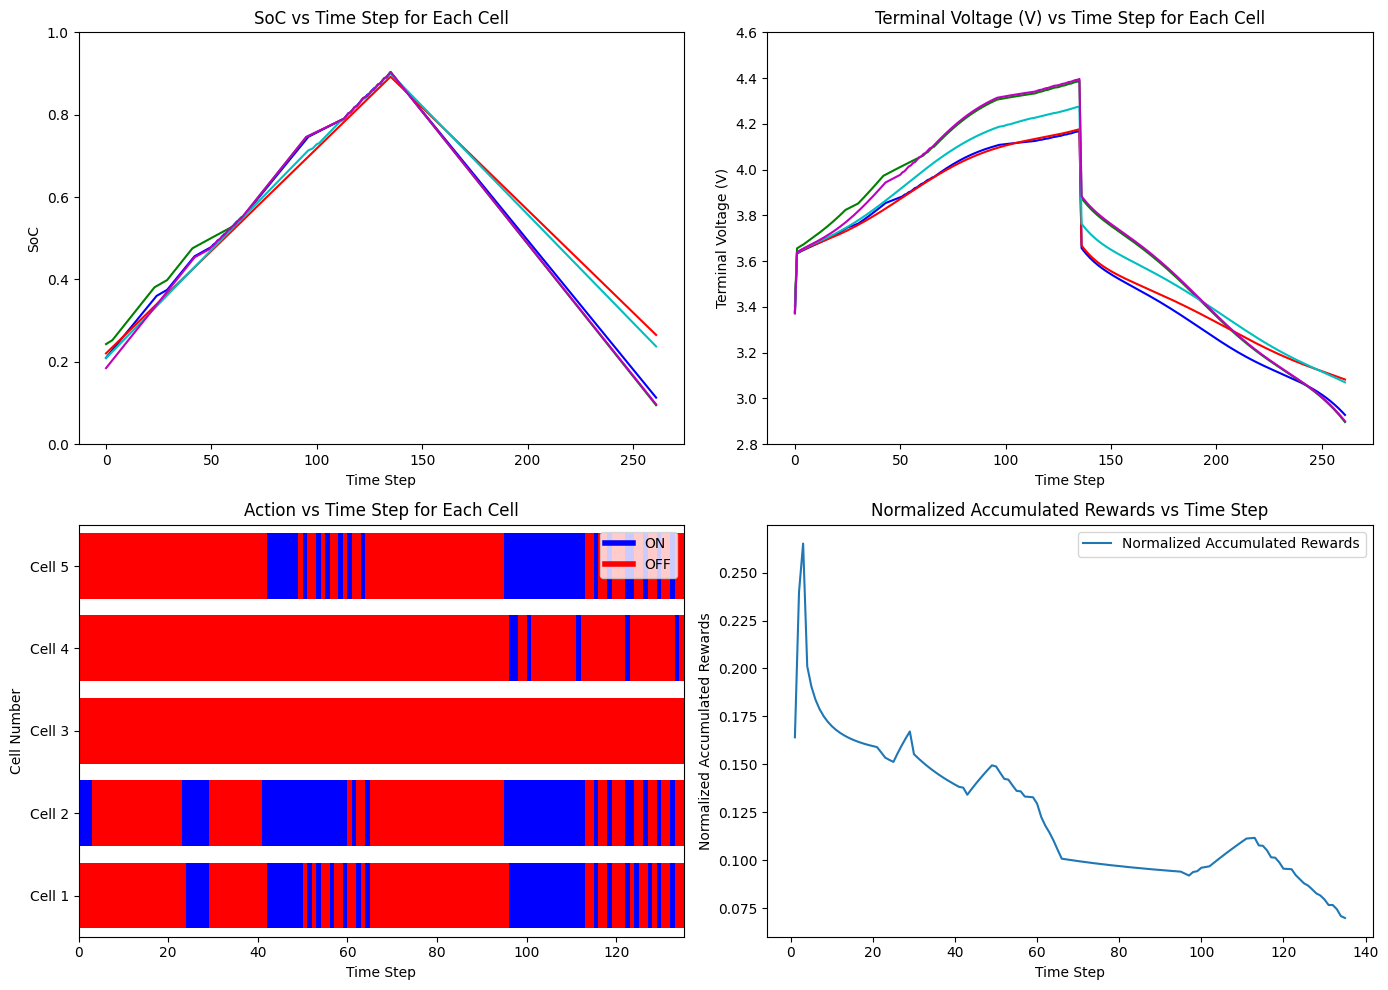

In [115]:
plot_bms_evolution(bms, states_soc_8, states_voltage_8, actions_8, rewards_8, dones_8, include_bad_rewards=False)


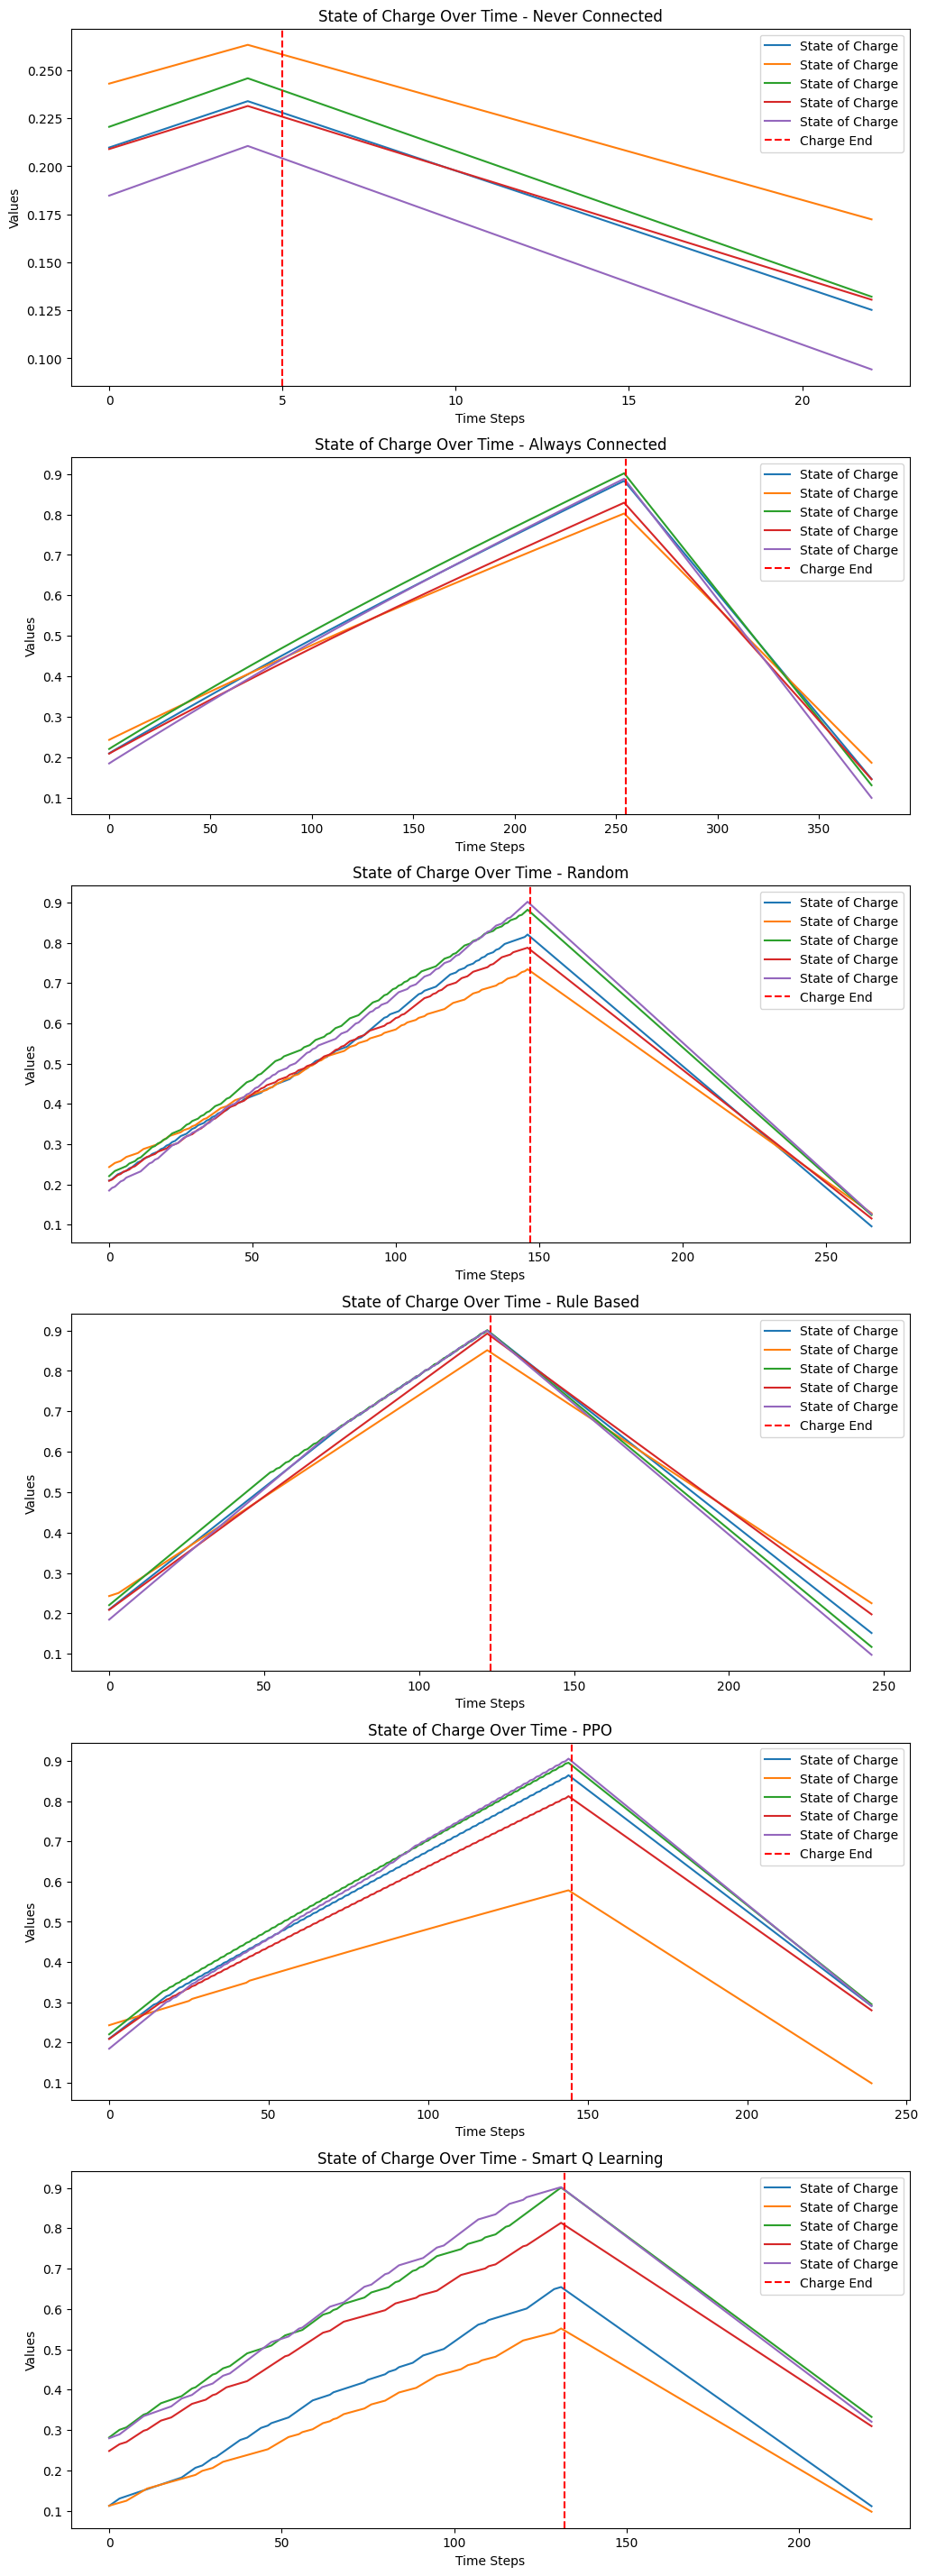

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(12, 36))  # Create a figure with 6 rows and 1 column

titles = ['Never Connected', 'Always Connected', 'Random', 'Rule Based', 'PPO', 'Smart Q Learning']
states = [states_soc_1, states_soc_2, states_soc_3, states_soc_4, states_soc_5, states_soc_6]
charge_ends = [charge_end_1, charge_end_2, charge_end_3, charge_end_4, charge_end_5, charge_end_6]

for i, ax in enumerate(axs):
    ax.plot(states[i], label='State of Charge')
    ax.set_title(f'State of Charge Over Time - {titles[i]}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Values')
    ax.axvline(x=charge_ends[i], color='r', linestyle='--', label='Charge End')
    ax.legend()

